# Random Forest Model:
@elivic734, @milli2908

This notebook demonstrates the workflow for building, tuning, and evaluating a Random Forest model for phage gene classification. We first illustrate our approach using an 80/20 train-test split, including parameter tuning and feature importance analysis. Afterwards, we apply the same procedure to each leave-one-out split. The model on the 80/20 split with the best accuracy and cv-score to date can be found in the first code cell. The optimized models for the leave-one-out splits are also provided in the last cell. All trained models are saved as .joblib files and the corresponding processed data, along with label encoders are stored as .pkl files under the data/RandomForest directory. Underneath you can find code we used to analize and optimize the model. The structure is as follows:

1. **80/20-Split**
    1. **Optimized Model**
    2. **Hyperparameter Tuning**
        - RandomizedSearchCV (broad search)
        - GridSearchCV (fine-tuning)
    3. **Visualization of Classification Distribution and Feature Importance**
    4. **Finding best number of Features**
5. **Leave-One-Out-Splits**
    1. **Optimized Models on each split in Leave-One-Out + Visualization**

---


In [226]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import joblib 
from sklearn.utils.class_weight import compute_sample_weight
import os
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder

## 1. Optimized Model on 80/20 split

In [228]:
# --- Data loading and preprocessing ---
train_df = pd.read_csv('../data/combined-data-stratified-split/train_data.tsv', sep='\t')
test_df = pd.read_csv('../data/combined-data-stratified-split/test_data.tsv', sep='\t')

# Create folder to store models and plots
os.makedirs("../data/RandomForest", exist_ok=True)

# Columns to drop
cols_to_drop = ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_y']

# Separate features and target variable
X_train_all_features = train_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')

X_test_all_features = test_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')

# Encode labels
le = LabelEncoder()
le.fit(["early", "middle", "late"]) 
y_train = le.fit_transform(train_df['classification_x'])
y_test = le.transform(test_df['classification_x'])


# --- Train a temporary model to get feature importances ---
rf_model_all_features = RandomForestClassifier(
    random_state=42,
    n_estimators=389,
    max_depth=13,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    class_weight='balanced_subsample'
)
rf_model_all_features.fit(X_train_all_features, y_train)

# --- Select top 36 features based on importance ---
importances = rf_model_all_features.feature_importances_
feature_names = X_train_all_features.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top36_features = feat_imp.index[:36].tolist()
print("Top 36 Features:", top36_features)

# --- Reduce datasets to top 36 features only ---
X_train = X_train_all_features[top36_features]
X_test = X_test_all_features[top36_features]

# --- Retrain model using only top 36 features ---
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=389,
    max_depth=13,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    class_weight='balanced_subsample'
)
rf_model.fit(X_train, y_train)

# --- Model evaluation ---
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross-validation on training data
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("CV-Score (mean):", cv_scores.mean())
print("CV-Scores (per fold):", cv_scores)

# Classification report on test data
print(classification_report(y_test, y_pred))

# save model
joblib.dump(rf_model, f"../data/RandomForest/model_split_6.joblib")

# save pickle
split = "80_20"
result = (X_train, y_train, X_test, y_test, le, split)
filepath = "../data/RandomForest/"
os.makedirs(os.path.dirname(filepath), exist_ok=True)
with open(f"../data/RandomForest/split_6_data.pkl", "wb") as f:
    pickle.dump(result, f)


Top 36 Features: ['Gene_Position_Relative', 'kmer_TGA', 'kmer_ATA', 'kmer_TTG', 'GC_Content', 'Seq_length', 'G_Content', 'C_Content', 'kmer_ACA', 'molecular_weight', 'kmer_ATG', 'kmer_TAT', 'seq_length', 'T_Content', 'kmer_GTT', 'kmer_TGG', 'kmer_TAG', 'kmer_TCT', 'kmer_CTG', 'A_Content', 'kmer_GAC', 'aromaticity', 'kmer_AAT', 'C_frac', 'kmer_CCG', 'kmer_CCC', 'kmer_AGA', 'kmer_TAA', 'kmer_GGC', 'GRAVY', 'kmer_AGC', 'kmer_TCA', 'kmer_GTA', 'kmer_CAT', 'kmer_TAC', 'kmer_CAC']
Accuracy: 0.683982683982684
CV-Score (mean): 0.6641421856639248
CV-Scores (per fold): [0.65405405 0.64324324 0.69189189 0.69021739 0.64130435]
              precision    recall  f1-score   support

           0       0.67      0.61      0.64        61
           1       0.70      0.75      0.72        92
           2       0.68      0.67      0.67        78

    accuracy                           0.68       231
   macro avg       0.68      0.67      0.68       231
weighted avg       0.68      0.68      0.68       2

## 2.1.  Hyperparameter Tuning: RandomSearchCV on 80/20 split

In [183]:
# --- Hyperparameter tuning with RandomizedSearchCV ---

param_dist = {
    'n_estimators': [50, 100, 150, 200, 300, 340, 350, 360, 400, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 35, 45],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'oob_score': [False, True],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print('Best parameters found:')
print(random_search.best_params_)

y_pred_best = random_search.predict(X_test)
print('Accuracy (best RF):', accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=log_loss, max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
215 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/base.py", line 469, in _validate_params
    v

Best parameters found:
{'oob_score': False, 'n_estimators': 340, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'bootstrap': False}
Accuracy (best RF): 0.6666666666666666
              precision    recall  f1-score   support

       early       0.62      0.66      0.63        61
        late       0.70      0.67      0.69        92
      middle       0.67      0.67      0.67        78

    accuracy                           0.67       231
   macro avg       0.66      0.67      0.66       231
weighted avg       0.67      0.67      0.67       231



## 2.2.  Hyperparameter Tuning: GridSearchCV on 80/20 split

In [184]:
# --- Hyperparameter tuning with GridSearchCV ---

param_grid = {
    'n_estimators': [389],
    'max_depth': [13],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='balanced_accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best CV score:', grid_search.best_score_)

y_pred_grid = grid_search.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.8s
Best parameters:

## 3. Visualization of Feature Importance on 80/20 split

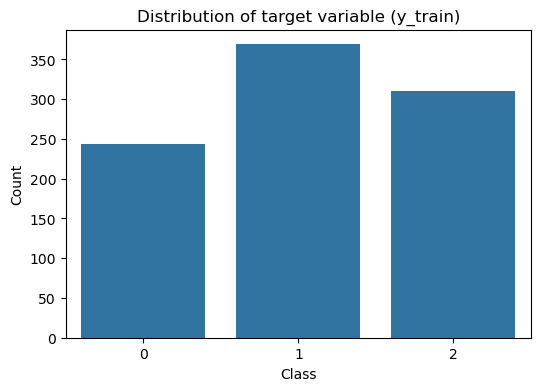

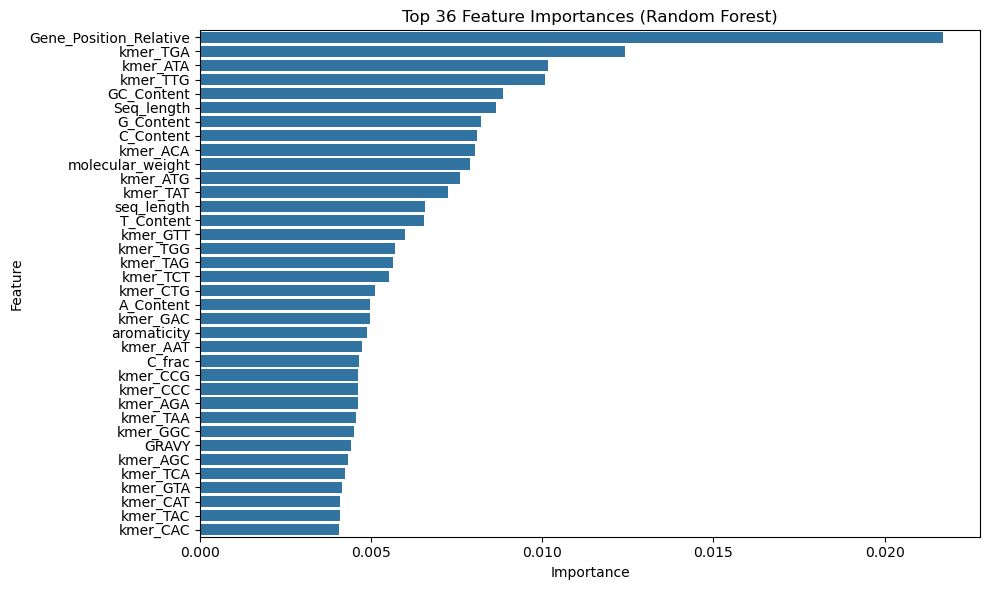

In [206]:
# --- Visualization: target distribution and feature importances ---

# Visualize target variable (y_train) distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Distribution of target variable (y_train)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize feature importances (after training!)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model_all_features.feature_importances_
    feature_names = X_train_all_features.columns
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values[:36], y=feat_imp.index[:36])
    plt.title('Top 36 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Feature importances not available for this model.')


## 4. Finding best number of Features on 80/20 split

In [187]:
# --- Feature number optimization: loop over top-n features ---
results = []
for n in range(1, 86):  # 1 to 86
    # Choose top-n features
    topn_features = feat_imp.index[:n].tolist()
    X_train_n = X_train_all_features[topn_features]
    X_test_n = X_test_all_features[topn_features]
    
    # GridSearchCV
    param_grid = {
        'n_estimators': [389],
        'max_depth': [13],
        'min_samples_split': [5],
        'min_samples_leaf': [1],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'criterion': ['gini'],
        'class_weight': ['balanced_subsample']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='balanced_accuracy', 
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_n, y_train)
    score = grid_search.best_score_
    results.append({'n_features': n, 'cv_score': score, 'params': grid_search.best_params_})
    print(f"Top {n} Features: CV-Score = {score:.3f}")

# Show results as DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
Top 1 Features: 

## 5. Optimized models on Leave-One-Out splits


=== Processing Split 0 ===


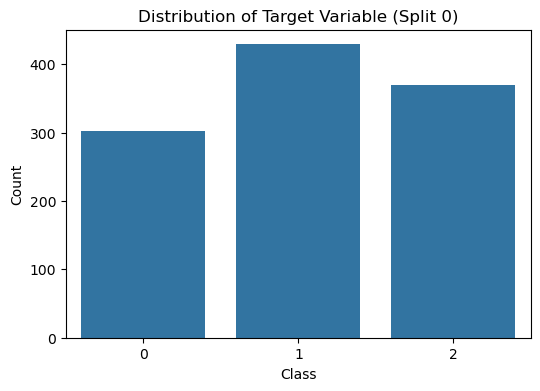

Top 8 features: CV balanced accuracy = 0.4358
Top 9 features: CV balanced accuracy = 0.4409
Top 10 features: CV balanced accuracy = 0.4380
Top 11 features: CV balanced accuracy = 0.4604
Top 12 features: CV balanced accuracy = 0.4562
Top 13 features: CV balanced accuracy = 0.4611
Top 14 features: CV balanced accuracy = 0.4627
Top 15 features: CV balanced accuracy = 0.4661
Top 16 features: CV balanced accuracy = 0.4597
Top 17 features: CV balanced accuracy = 0.4603
Top 18 features: CV balanced accuracy = 0.4748
Top 19 features: CV balanced accuracy = 0.4792
Top 20 features: CV balanced accuracy = 0.4780
Top 21 features: CV balanced accuracy = 0.4807
Top 22 features: CV balanced accuracy = 0.4922
Top 23 features: CV balanced accuracy = 0.4946
Top 24 features: CV balanced accuracy = 0.5012
Top 25 features: CV balanced accuracy = 0.4750
Top 26 features: CV balanced accuracy = 0.4953
Top 27 features: CV balanced accuracy = 0.4780
Top 28 features: CV balanced accuracy = 0.4894
Top 29 features

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

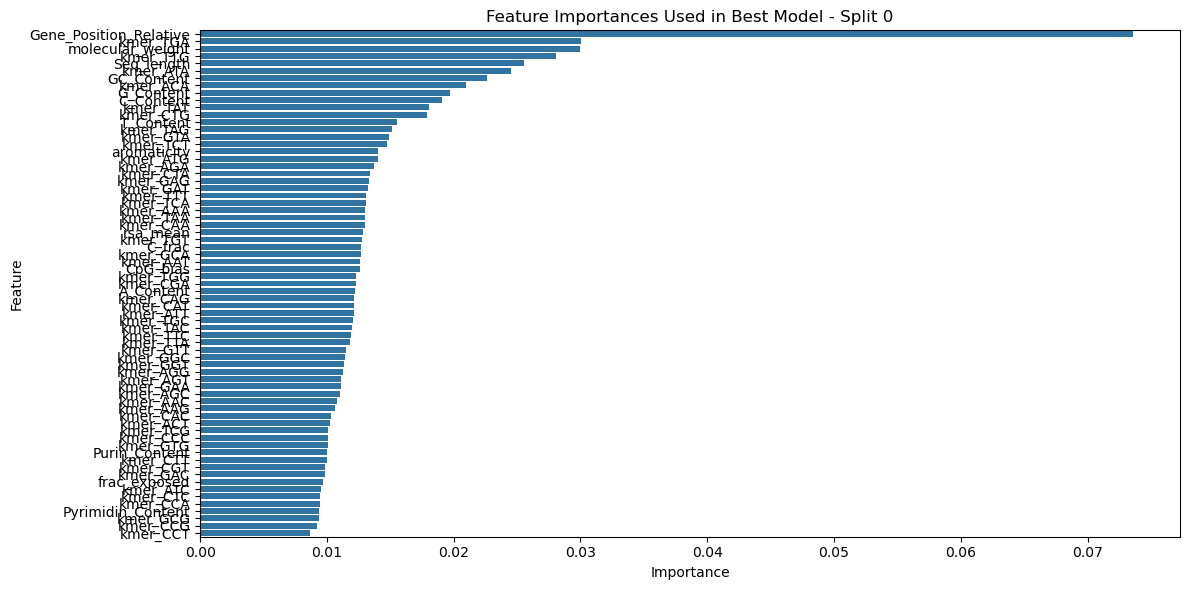


=== Processing Split 1 ===


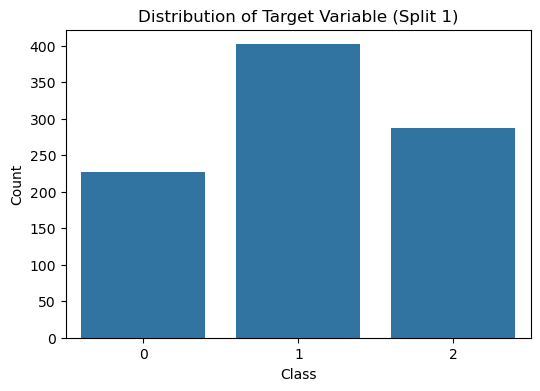

Top 8 features: CV balanced accuracy = 0.4447
Top 9 features: CV balanced accuracy = 0.4082
Top 10 features: CV balanced accuracy = 0.4314
Top 11 features: CV balanced accuracy = 0.4517
Top 12 features: CV balanced accuracy = 0.4497
Top 13 features: CV balanced accuracy = 0.4567
Top 14 features: CV balanced accuracy = 0.4690
Top 15 features: CV balanced accuracy = 0.4586
Top 16 features: CV balanced accuracy = 0.4444
Top 17 features: CV balanced accuracy = 0.4681
Top 18 features: CV balanced accuracy = 0.4609
Top 19 features: CV balanced accuracy = 0.4660
Top 20 features: CV balanced accuracy = 0.4735
Top 21 features: CV balanced accuracy = 0.4725
Top 22 features: CV balanced accuracy = 0.4856
Top 23 features: CV balanced accuracy = 0.4931
Top 24 features: CV balanced accuracy = 0.4961
Top 25 features: CV balanced accuracy = 0.4629
Top 26 features: CV balanced accuracy = 0.4812
Top 27 features: CV balanced accuracy = 0.4801
Top 28 features: CV balanced accuracy = 0.5025
Top 29 features

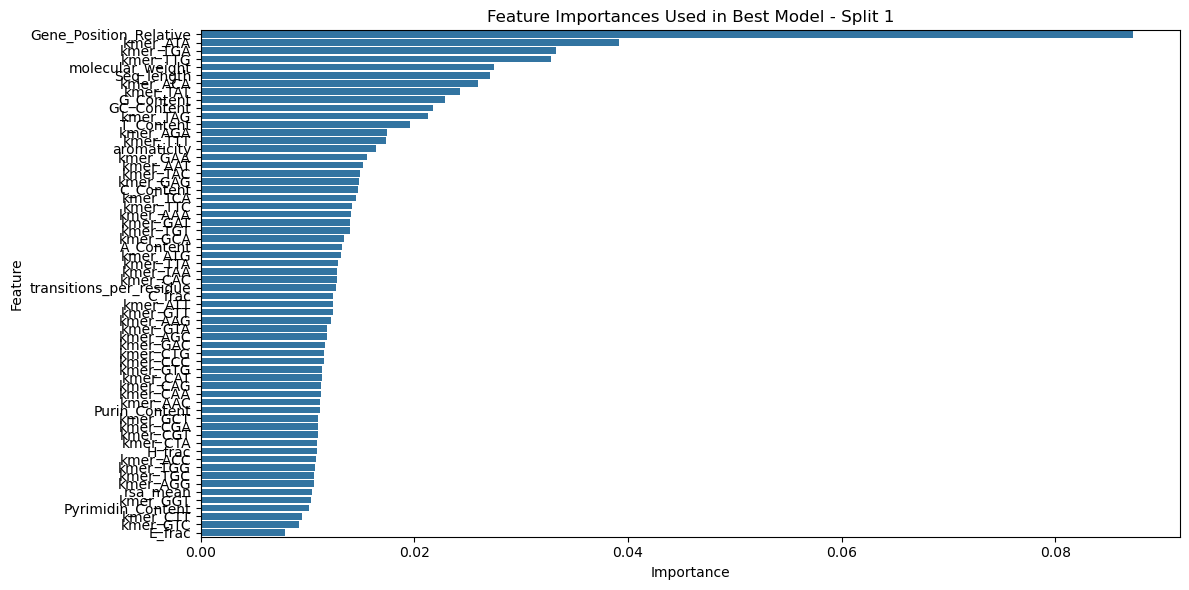


=== Processing Split 2 ===


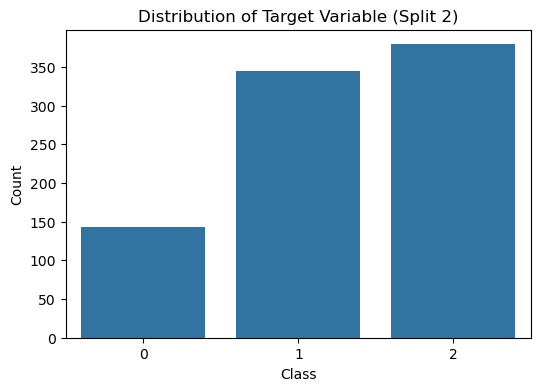

Top 8 features: CV balanced accuracy = 0.4169
Top 9 features: CV balanced accuracy = 0.4166
Top 10 features: CV balanced accuracy = 0.4215
Top 11 features: CV balanced accuracy = 0.4485
Top 12 features: CV balanced accuracy = 0.4491
Top 13 features: CV balanced accuracy = 0.4586
Top 14 features: CV balanced accuracy = 0.4565
Top 15 features: CV balanced accuracy = 0.4765
Top 16 features: CV balanced accuracy = 0.4644
Top 17 features: CV balanced accuracy = 0.4508
Top 18 features: CV balanced accuracy = 0.4597
Top 19 features: CV balanced accuracy = 0.4667
Top 20 features: CV balanced accuracy = 0.4802
Top 21 features: CV balanced accuracy = 0.4780
Top 22 features: CV balanced accuracy = 0.4722
Top 23 features: CV balanced accuracy = 0.4982
Top 24 features: CV balanced accuracy = 0.4962
Top 25 features: CV balanced accuracy = 0.4842
Top 26 features: CV balanced accuracy = 0.4752
Top 27 features: CV balanced accuracy = 0.4657
Top 28 features: CV balanced accuracy = 0.4861
Top 29 features

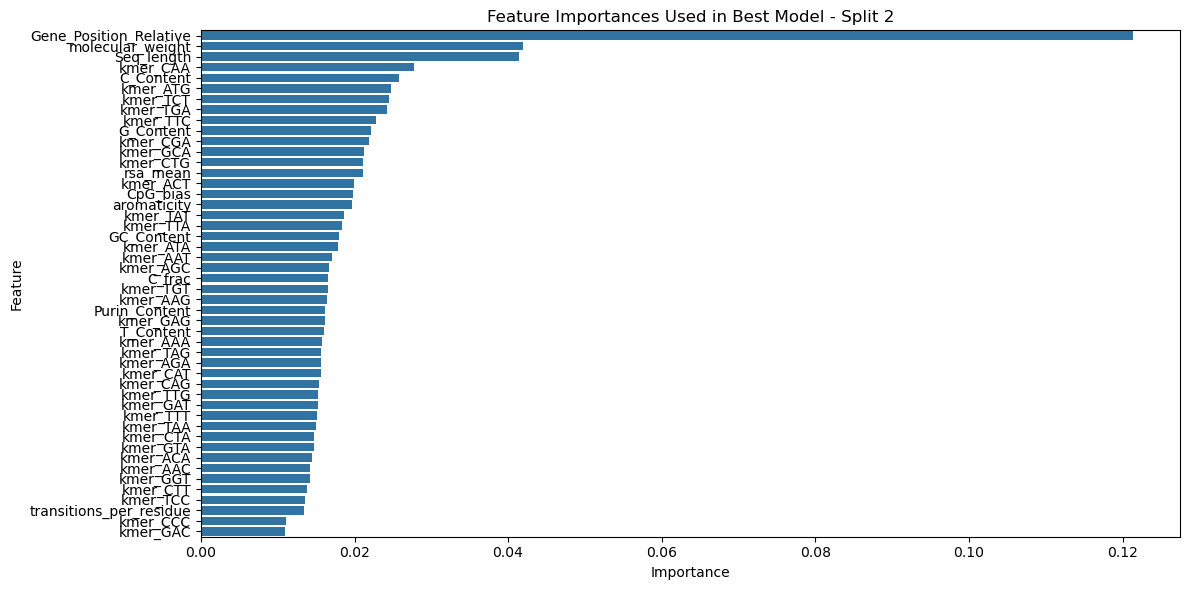


=== Processing Split 3 ===


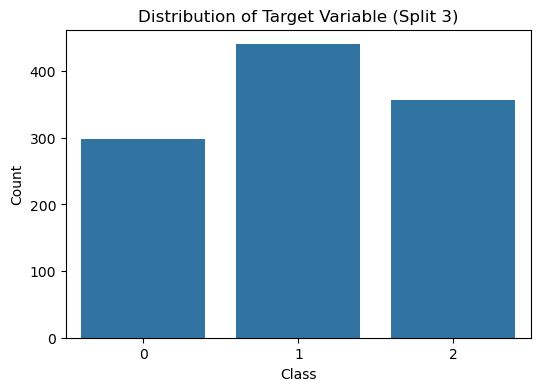

Top 8 features: CV balanced accuracy = 0.4783
Top 9 features: CV balanced accuracy = 0.4510
Top 10 features: CV balanced accuracy = 0.4750
Top 11 features: CV balanced accuracy = 0.4849
Top 12 features: CV balanced accuracy = 0.4818
Top 13 features: CV balanced accuracy = 0.4868
Top 14 features: CV balanced accuracy = 0.4942
Top 15 features: CV balanced accuracy = 0.4933
Top 16 features: CV balanced accuracy = 0.5084
Top 17 features: CV balanced accuracy = 0.4935
Top 18 features: CV balanced accuracy = 0.4947
Top 19 features: CV balanced accuracy = 0.5015
Top 20 features: CV balanced accuracy = 0.5145
Top 21 features: CV balanced accuracy = 0.5094
Top 22 features: CV balanced accuracy = 0.5122
Top 23 features: CV balanced accuracy = 0.5195
Top 24 features: CV balanced accuracy = 0.5097
Top 25 features: CV balanced accuracy = 0.5107
Top 26 features: CV balanced accuracy = 0.5133
Top 27 features: CV balanced accuracy = 0.5196
Top 28 features: CV balanced accuracy = 0.5159
Top 29 features

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

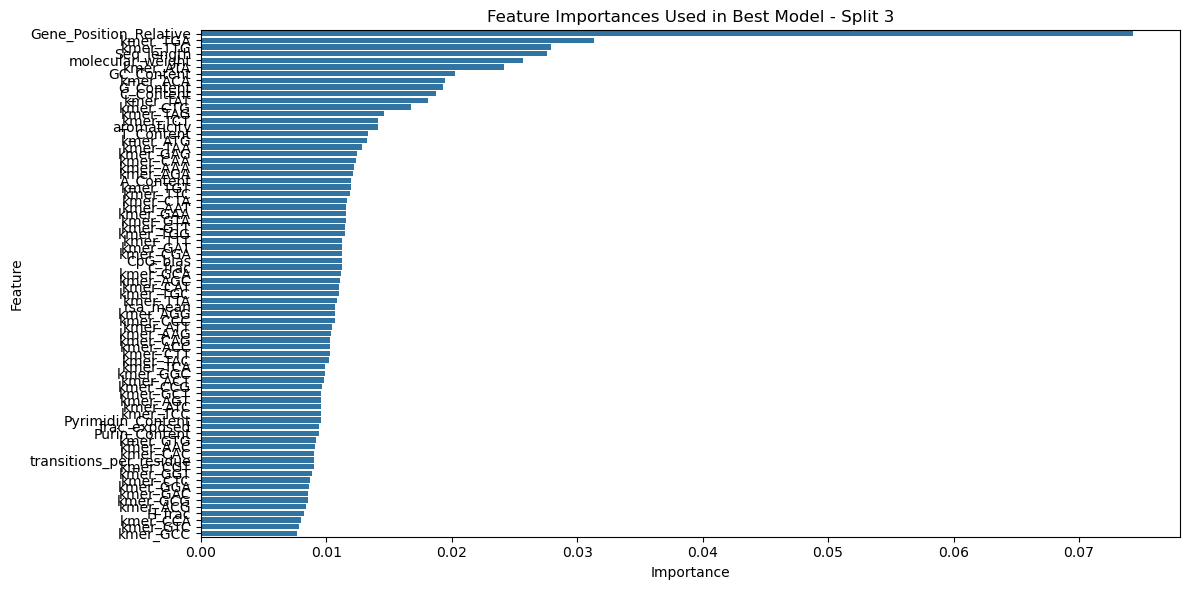


=== Processing Split 4 ===


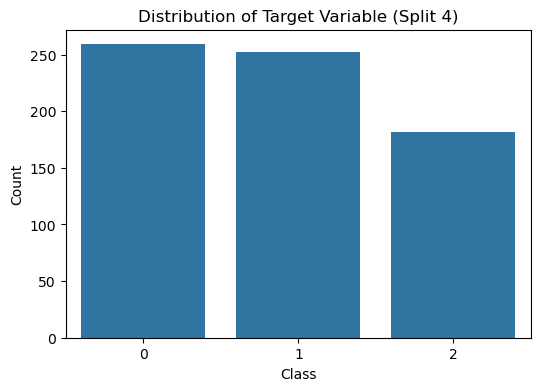

Top 8 features: CV balanced accuracy = 0.5582
Top 9 features: CV balanced accuracy = 0.5585
Top 10 features: CV balanced accuracy = 0.5519
Top 11 features: CV balanced accuracy = 0.5257
Top 12 features: CV balanced accuracy = 0.5403
Top 13 features: CV balanced accuracy = 0.5254
Top 14 features: CV balanced accuracy = 0.5401
Top 15 features: CV balanced accuracy = 0.5365
Top 16 features: CV balanced accuracy = 0.5542
Top 17 features: CV balanced accuracy = 0.5389
Top 18 features: CV balanced accuracy = 0.5415
Top 19 features: CV balanced accuracy = 0.5400
Top 20 features: CV balanced accuracy = 0.5390
Top 21 features: CV balanced accuracy = 0.5459
Top 22 features: CV balanced accuracy = 0.5442
Top 23 features: CV balanced accuracy = 0.5505
Top 24 features: CV balanced accuracy = 0.5367
Top 25 features: CV balanced accuracy = 0.5432
Top 26 features: CV balanced accuracy = 0.5313
Top 27 features: CV balanced accuracy = 0.5340
Top 28 features: CV balanced accuracy = 0.5415
Top 29 features

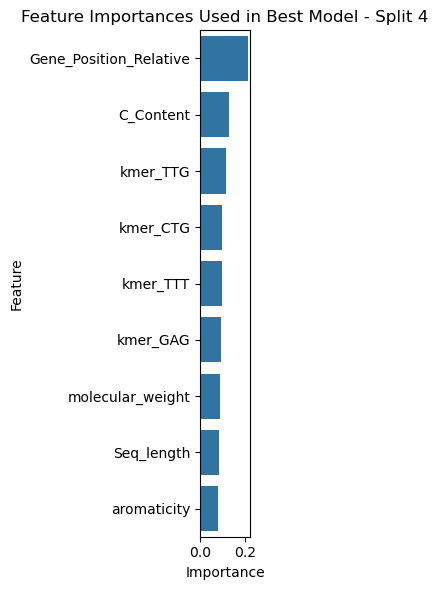


=== Processing Split 5 ===


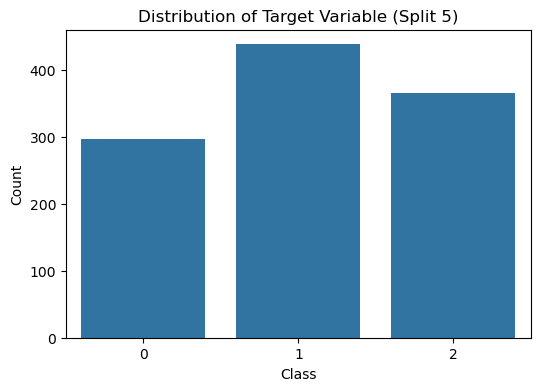

Top 8 features: CV balanced accuracy = 0.4391
Top 9 features: CV balanced accuracy = 0.4306
Top 10 features: CV balanced accuracy = 0.4449
Top 11 features: CV balanced accuracy = 0.4668
Top 12 features: CV balanced accuracy = 0.4676
Top 13 features: CV balanced accuracy = 0.4806
Top 14 features: CV balanced accuracy = 0.4769
Top 15 features: CV balanced accuracy = 0.4889
Top 16 features: CV balanced accuracy = 0.4771
Top 17 features: CV balanced accuracy = 0.4759
Top 18 features: CV balanced accuracy = 0.4876
Top 19 features: CV balanced accuracy = 0.5022
Top 20 features: CV balanced accuracy = 0.4891
Top 21 features: CV balanced accuracy = 0.4902
Top 22 features: CV balanced accuracy = 0.4946
Top 23 features: CV balanced accuracy = 0.5033
Top 24 features: CV balanced accuracy = 0.5064
Top 25 features: CV balanced accuracy = 0.4999
Top 26 features: CV balanced accuracy = 0.5059
Top 27 features: CV balanced accuracy = 0.5068
Top 28 features: CV balanced accuracy = 0.5100
Top 29 features

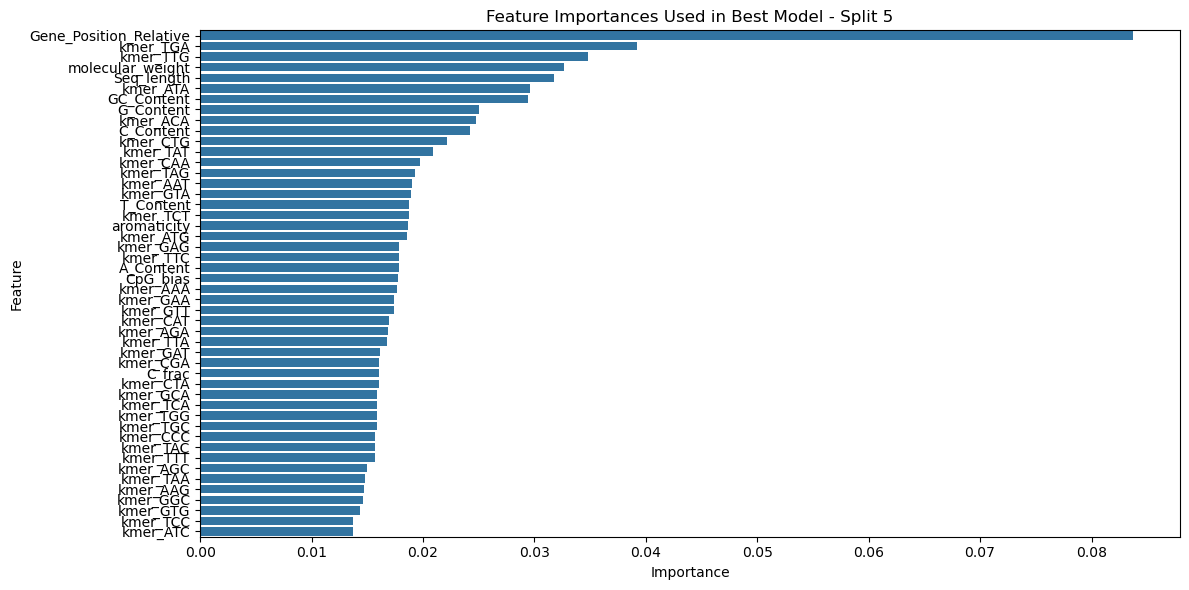

In [229]:
# --- Random Forest Model for the Leave-One-Group-Out Splits ---

# --- Configuration ---
cols_to_drop = ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_y', 'group']
param_grid = {
    'n_estimators': [389],
    'max_depth': [13],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced_subsample']
}

num_splits = 6  # Adjust according to your splits count

os.makedirs("../data/RandomForest", exist_ok=True)

# --- Loop over splits ---
for split in range(num_splits):
    print(f"\n=== Processing Split {split} ===")

    # Load train and test data
    train_df = pd.read_csv(f'../data/leave-one-group-out-split/splits/train_split_{split}.tsv', sep='\t')
    test_df = pd.read_csv(f'../data/leave-one-group-out-split/splits/test_split_{split}.tsv', sep='\t')

    # Label encoding with fixed class order for consistent mapping
    le = LabelEncoder()
    le.fit(["early", "middle", "late"])
    train_df["classification_x"] = le.transform(train_df["classification_x"])
    test_df["classification_x"] = le.transform(test_df["classification_x"])

    # Separate features and target variable
    X_train_all = train_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')
    y_train = train_df['classification_x']
    X_test_all = test_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')
    y_test = test_df['classification_x']

    # --- Visualization: Target distribution in training set ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train)
    plt.title(f'Distribution of Target Variable (Split {split})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    # Train initial Random Forest to get feature importances
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_all, y_train)

    importances = rf_model.feature_importances_
    feature_names = X_train_all.columns
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    # Limit search to between 10% and 90% of total features
    n_features = len(feat_imp)
    start_idx = max(1, int(n_features * 0.10))
    end_idx = max(start_idx + 1, int(n_features * 0.90))

    best_score = 0
    best_model = None
    best_n = 0

    # Feature number optimization loop
    for n in range(start_idx, end_idx + 1):
        top_features = feat_imp.index[:n].tolist()

        X_train_n = X_train_all[top_features]

        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_n, y_train)
        score = grid_search.best_score_

        print(f"Top {n} features: CV balanced accuracy = {score:.4f}")

        if score > best_score:
            best_score = score
            best_model = grid_search.best_estimator_
            best_n = n
    print(f"Best number of features for split {split}: {best_n}")        

    # Final evaluation on test set with best model and features
    top_features = feat_imp.index[:best_n].tolist()
    best_model.fit(X_train_all[top_features], y_train)
    y_pred = best_model.predict(X_test_all[top_features])

    # Print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nSplit {split} Results:")
    print(f"Accuracy: {accuracy:.6f}")

    cv_scores = cross_val_score(best_model, X_train_all[top_features], y_train, cv=5, scoring='accuracy')
    print(f"CV-Score (mean): {cv_scores.mean():.6f}")
    print(f"CV-Scores (per fold): {list(cv_scores)}")

    print(classification_report(y_test, y_pred))

    # --- Visualization: Feature importances from the best model ---
    if hasattr(best_model, 'feature_importances_'):
        best_importances = best_model.feature_importances_
        best_feat_imp = pd.Series(best_importances, index=top_features).sort_values(ascending=False)

        plt.figure(figsize=(min(12, 0.3 * len(best_feat_imp)), 6))  # dynamic width
        sns.barplot(x=best_feat_imp.values, y=best_feat_imp.index)
        plt.title(f'Feature Importances Used in Best Model - Split {split}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    else:
        print('Feature importances not available for the best model.')

    # Save best model
    model_path = f"../data/RandomForest/model_split_{split}.joblib"
    joblib.dump(best_model, model_path)

    # Save processed data and encoder
    data_path = f"../data/RandomForest/split_{split}_data.pkl"
    with open(data_path, "wb") as f:
        pickle.dump((X_train_all[top_features], y_train, X_test_all[top_features], y_test, le, split), f)
